<a href="https://colab.research.google.com/github/DEKDEGUE-Hajar/Sentiment-Analysis/blob/main/Analyse_de_sentiments_Bert_Fine_Tuning%2Cipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Darija Sentiment Analysis Notebook***

## **Overview**
This notebook is dedicated to performing sentiment analysis on Moroccan Darija (Moroccan Arabic) tweets. The goal is to classify tweets as either positive or negative using a pre-trained BERT model fine-tuned on a dataset of Moroccan Darija tweets. The notebook follows a structured approach, starting from data loading and preprocessing to model training, evaluation, and prediction.

## **Steps**

### 1. Importing Libraries
Necessary libraries such as transformers, torch, and pandas are installed and imported.

Google Drive is mounted to access the dataset stored in the cloud.

### 2. Dataset Loading:

The dataset is loaded from an Excel file
: [ElecMorocco2016.xlsx](https://github.com/sentiprojects/ElecMorocco2016/blob/master/ElecMorocco2016.xlsx), which contains 10254 Arabic facebook comments about the Moroccan elections of 2016 and their corresponding labels (positive or negative). The comments are written in standard arabic and morrocan dialect.

### 3. Dataset Cleaning and Visualization:

The dataset is cleaned by dropping unnecessary columns, renaming columns for clarity, and mapping the labels to binary values (0 for negative, 1 for positive). Additionally, the text data is cleaned by removing stop words, which are common words that do not contribute significantly to the sentiment analysis. Stop words in Darija (Moroccan Arabic) are obtained from a predefined list, and domain-specific stop words (e.g., "الله", "بنكيران", "المغرب") are added to ensure the cleaning process is tailored to the dataset. These domain-specific stop words are removed because they hold no sentiment and would not be useful for the model. The cleaning process also includes removing mentions, hashtags, URLs, non-Arabic characters, and short words (length ≤ 2). After cleaning, the dataset is visualized by plotting the top 25 most common words to gain insights into the most frequent terms in the cleaned text. This step helps in understanding the dataset and ensuring the text is ready for further analysis.

### 4. Data Splitting:

The dataset is split into training and testing sets using an 80-20 split ratio.

### 5. Tokenization and Input Formatting:

In this step, I used BERT's tokenizer to convert the text data into a format suitable for model input, ensuring uniform length for all sentences and creating attention masks for padding, then The tokenized data and labels were converted into tensors and loaded into PyTorch DataLoaders. This enables efficient batch processing during model training and evaluation.

### 6. Model Training:

A custom BERT classifier is defined, which consists of a BERT model followed by a feed-forward classifier.

The model is trained on the training dataset for 2 epochs, with evaluation performed on the validation set after each epoch.

The training process includes loss calculation, gradient clipping, and learning rate scheduling.

### 7. Predicting & Evaluating the model:

The trained model is evaluated on the test set using ROC-AUC and accuracy metrics.

A ROC curve is plotted to visualize the model's performance.


## 1. Importing Libraries

In [ ]:
import pandas as pd
import re
import torch
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 2. Loading The  Dataset

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
df = pd.read_excel("/content/drive/MyDrive/nlp-project/ElecMorocco2016.xlsx")

In [ ]:
df.head()

,index,comment_message,sentiment,comment_published
0,1,البكاء ليس سمت الرجال ..البكاء سلطة الضعفاء لك...,N,2016-10-01 00:07:44
1,2,كلنا بنكيران\nولاية ثانية ان شاء الله\nموتوا ب...,P,2016-10-01 00:47:37
2,3,الشركات في الدول المتقدمة تساهم في بناء أوطانه...,N,2016-10-01 00:48:02
3,4,من ينتقد بن كران هم خصوم معارضة لى خاصها هي سل...,N,2016-10-01 00:49:10
4,5,هدو صحاب بام توجدو راسهوم بغين اعفاءات ضريبية ...,N,2016-10-01 00:59:47


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10254 entries, 0 to 10253
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              10254 non-null  int64 
 1   comment_message    10254 non-null  object
 2   sentiment          10254 non-null  object
 3   comment_published  10254 non-null  object
dtypes: int64(1), object(3)
memory usage: 320.6+ KB


In [ ]:
# check for missing values
df.isnull().sum()

,0
index,0
comment_message,0
sentiment,0
comment_published,0


In [ ]:
# Check for the class balance
df['sentiment'].value_counts(normalize=True)

,proportion
sentiment,
N,0.641798
P,0.358202


<Axes: xlabel='sentiment'>

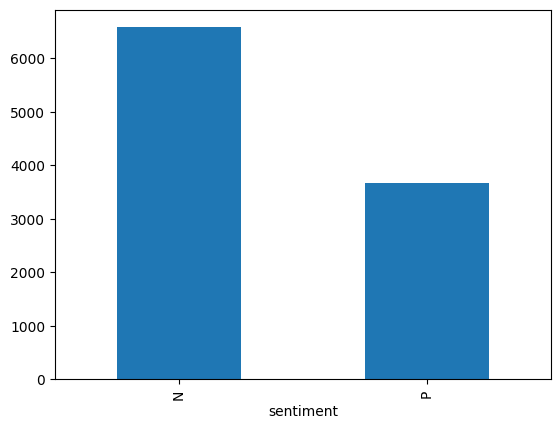

In [ ]:
# plot the label counts
df['sentiment'].value_counts().plot(kind='bar')

## 3. Data Cleaning and visualization

In [ ]:
df.drop(columns=['index','comment_published'], inplace=True)

In [ ]:
df.columns = ['text', 'label']

In [ ]:
# Mapping 'pos' to 0 and 'neg' to 1
df['label'] = df['label'].map({'N': 0, 'P': 1})

In [ ]:
df.head()

,text,label
0,البكاء ليس سمت الرجال ..البكاء سلطة الضعفاء لك...,0
1,كلنا بنكيران\nولاية ثانية ان شاء الله\nموتوا ب...,1
2,الشركات في الدول المتقدمة تساهم في بناء أوطانه...,0
3,من ينتقد بن كران هم خصوم معارضة لى خاصها هي سل...,0
4,هدو صحاب بام توجدو راسهوم بغين اعفاءات ضريبية ...,0


**Data with no cleaning**

In [ ]:
#collect all the words from all the comments into a single list
all_words = []
for t in df['text']:
    all_words.extend(t.split())

print(all_words[:50])
len(set(all_words)) # this is the number of unique words in the list

['البكاء', 'ليس', 'سمت', 'الرجال', '..البكاء', 'سلطة', 'الضعفاء', 'لكسب', 'التعاطف', '..انا', 'لست', 'ضد', 'بنكيران', 'وانما', 'الرجل', 'الصالح', 'هو', 'الذي', 'يفعل', 'ما', 'يقول', 'ولا', 'يبكي', 'الا', 'عند', 'النصر', 'كلنا', 'بنكيران', 'ولاية', 'ثانية', 'ان', 'شاء', 'الله', 'موتوا', 'بحقدكم', 'الشركات', 'في', 'الدول', 'المتقدمة', 'تساهم', 'في', 'بناء', 'أوطانها', 'بدفع', 'الضرائب', 'وفي', 'بلدنا', 'العزيز', 'الشركات', 'تطلب']


40627

In [ ]:
pip install arabic-reshaper python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.6/286.6 kB 20.0 MB/s eta 0:00:00


<ipython-input-15-cd3eec3f89e1>:30: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


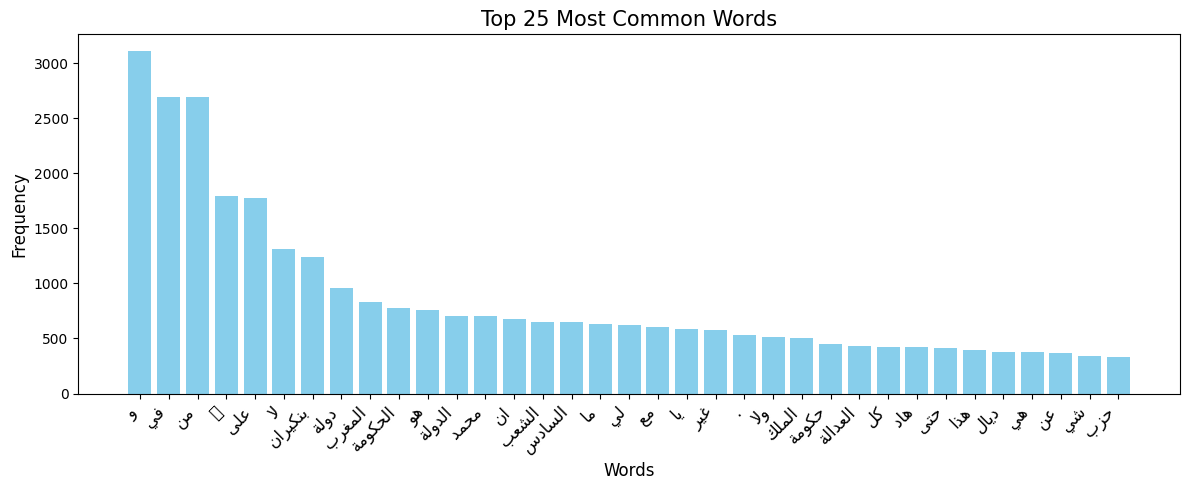

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import arabic_reshaper
from bidi.algorithm import get_display

# Collect all the words from all the tweets
all_words = []
for t in df['text']:
    all_words.extend(t.split())

# Use Counter to count frequencies of each word
word_freq = Counter(all_words)

# Get the 25 most common words
most_common_25 = word_freq.most_common(35)

# Separate the words and their frequencies for plotting
words, freqs = zip(*most_common_25)

# Reshape and reorder Arabic text for proper display
reshaped_words = [get_display(arabic_reshaper.reshape(word)) for word in words]

# Plot the 25 most frequent words
plt.figure(figsize=(12, 5))
plt.bar(reshaped_words, freqs, color='skyblue')
plt.title('Top 25 Most Common Words', fontsize=15)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

**data cleaned with stop words**

In [ ]:

def text_cleaner_with_stopwords_darija(text):
    # Remove mentions (e.g., @username)
    new_text = re.sub(r"@[A-Za-z0-9_]+", "", text)

    # Remove hashtags (but keep the word after the hashtag)
    new_text = re.sub("#", "", new_text)

    # Remove URLs
    new_text = re.sub(r"http\S+", "", new_text)

    # Remove any non-Arabic characters (keeping spaces and Arabic letters)
    new_text = re.sub(r"[^\u0621-\u064A\s]", "", new_text)  # Unicode range for Arabic script

    # Remove newline characters, tabs, and carriage returns
    new_text = re.sub(r"[\n\r\t]", " ", new_text)  # Replace \n, \r, \t with a space

    # Replace multiple consecutive spaces with a single space
    new_text = re.sub(r"\s+", " ", new_text)

    # Remove short words (length <= 2)
    new_text = [token for token in new_text.split() if len(token) > 2]

    # Join the cleaned tokens back into a single string
    new_text = " ".join(new_text).strip()  # Strip leading/trailing spaces

    return new_text

In [ ]:
cleaned_text_with_stopwords = list(df['text'].apply(text_cleaner_with_stopwords_darija))
print(cleaned_text_with_stopwords[:10])

['البكاء ليس سمت الرجال البكاء سلطة الضعفاء لكسب التعاطف انا لست بنكيران وانما الرجل الصالح الذي يفعل يقول ولا يبكي الا عند النصر', 'كلنا بنكيران ولاية ثانية شاء الله موتوا بحقدكم', 'الشركات الدول المتقدمة تساهم بناء أوطانها بدفع الضرائب وفي بلدنا العزيز الشركات تطلب الدولة تخدم عليها', 'ينتقد كران خصوم معارضة خاصها سلطة تهتم لوضعية مواطن', 'هدو صحاب بام توجدو راسهوم بغين اعفاءات ضريبية لهوم هما ويزيدها على فقراء يزدو ليه فلعشا مشى بطروناج شدها حزب البام مشيتو فيها المغاربة', 'نظرك الحكومات السابقة كانت احسن اتقوا الله وانظروا إلى المحاسن الى المساولا نسيتوا مضى الاستقلالاين الاشتراكيين', 'رئيس الحكومة يمر بتجربة صعبة للغاية فرغم التحديات والصعوبات والمواجهات التماسيح والعفاريت فشعبيته تزايد فالحق يعلى ولا يعلى عليه', 'مستوى االعيش بلادنا مثل فرنسا يونان اسبانيا لنقوم بسياسة تقشفهمادلتكم زاءفة كالعادة', 'احسن حكومة المغرب ساصوت على العدالة والتنمية اناس شرفاء يسرقوا بلدنا النصر حليفهم شاء الله', 'المنافقين هما البام مزال معرفتهم كيسواو ينجحوا وعاد تعرفهم على حقيقتهم']


In [ ]:
df['cleaned_text_with_stopwords'] = cleaned_text_with_stopwords
df.head()

,text,label,cleaned_text_with_stopwords
0,البكاء ليس سمت الرجال ..البكاء سلطة الضعفاء لك...,0,البكاء ليس سمت الرجال البكاء سلطة الضعفاء لكسب...
1,كلنا بنكيران\nولاية ثانية ان شاء الله\nموتوا ب...,1,كلنا بنكيران ولاية ثانية شاء الله موتوا بحقدكم
2,الشركات في الدول المتقدمة تساهم في بناء أوطانه...,0,الشركات الدول المتقدمة تساهم بناء أوطانها بدفع...
3,من ينتقد بن كران هم خصوم معارضة لى خاصها هي سل...,0,ينتقد كران خصوم معارضة خاصها سلطة تهتم لوضعية ...
4,هدو صحاب بام توجدو راسهوم بغين اعفاءات ضريبية ...,0,هدو صحاب بام توجدو راسهوم بغين اعفاءات ضريبية ...


**data cleaned without stop words**

In [ ]:
darija_stopwords = requests.get("https://raw.githubusercontent.com/ouladck/darija-stop-words/master/list.txt").text.splitlines()

print(darija_stopwords)


['،', 'ء', 'ءَ', 'آ', 'آب', 'آذار', 'آض', 'آل', 'آمينَ', 'آناء', 'آنفا', 'آه', 'آهاً', 'آهٍ', 'آهِ', 'أ', 'أبدا', 'أبريل', 'أبو', 'أبٌ', 'أجل', 'أجمع', 'أحد', 'أخبر', 'أخذ', 'أخو', 'أخٌ', 'أربع', 'أربعاء', 'أربعة', 'أربعمئة', 'أربعمائة', 'أرى', 'أسكن', 'أصبح', 'أصلا', 'أضحى', 'أطعم', 'أعطى', 'أعلم', 'أغسطس', 'أفريل', 'أفعل به', 'أفٍّ', 'أقبل', 'أكتوبر', 'أل', 'ألا', 'ألف', 'ألفى', 'أم', 'أما', 'أمام', 'أمامك', 'أمامكَ', 'أمد', 'أمس', 'أمسى', 'أمّا', 'أن', 'أنا', 'أنبأ', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'أنتِ', 'أنشأ', 'أنه', 'أنًّ', 'أنّى', 'أهلا', 'أو', 'أوت', 'أوشك', 'أول', 'أولئك', 'أولاء', 'أولالك', 'أوّهْ', 'أى', 'أي', 'أيا', 'أيار', 'أيضا', 'أيلول', 'أين', 'أيّ', 'أيّان', 'أُفٍّ', 'ؤ', 'إحدى', 'إذ', 'إذا', 'إذاً', 'إذما', 'إذن', 'إزاء', 'إلى', 'إلي', 'إليكم', 'إليكما', 'إليكنّ', 'إليكَ', 'إلَيْكَ', 'إلّا', 'إمّا', 'إن', 'إنَّ', 'إى', 'إياك', 'إياكم', 'إياكما', 'إياكن', 'إيانا', 'إياه', 'إياها', 'إياهم', 'إياهما', 'إياهن', 'إياي', 'إيهٍ', 'ئ', 'ا', 'ا?', 'ا?ى', 'االا', 'االتى', 'اب

In [ ]:
domain_stopwords = ['الله', 'بنكيران', 'دولة', 'المغرب', 'الحكومة', 'الدولة', 'محمد', 'الشعب',
                    'السادس', 'الملك', 'حكومة', 'العدالة', 'هاد', 'ديال', 'حزب', 'فكري', 'محسن',
                    'السياسة', 'رئيس', 'راه', 'المغاربة', 'كيران', 'الحسيمة', 'التنمية',]
final_stopwords = domain_stopwords + darija_stopwords

In [ ]:
def text_cleaner_without_stopwords_darija(text):
    # Remove mentions (e.g., @username)
    new_text = re.sub(r"@[A-Za-z0-9_]+", "", text)

    # Remove hashtags (but keep the word after the hashtag)
    new_text = re.sub("#", "", new_text)

    # Remove URLs
    new_text = re.sub(r"http\S+", "", new_text)

    # Remove any non-Arabic characters (keeping spaces and Arabic letters)
    new_text = re.sub(r"[^\u0621-\u064A\s]", "", new_text)  # Unicode range for Arabic script

    # Remove newline characters, tabs, and carriage returns
    new_text = re.sub(r"[\n\r\t]", " ", new_text)  # Replace \n, \r, \t with a space

    # Replace multiple consecutive spaces with a single space
    new_text = re.sub(r"\s+", " ", new_text)

    # Remove short words (length <= 2)
    new_text = [token for token in new_text.split() if len(token) > 2]

    # Remove stopwords
    new_text = [token for token in new_text if token not in final_stopwords]

    # Join the cleaned tokens back into a single string
    new_text = " ".join(new_text).strip()  # Strip leading/trailing spaces

    return new_text

In [ ]:
cleaned_text_without_stopwords = list(df['text'].apply(text_cleaner_without_stopwords_darija))
print(cleaned_text_without_stopwords[:10])

['البكاء سمت الرجال البكاء سلطة الضعفاء لكسب التعاطف انا لست وانما الرجل الصالح يفعل يقول يبكي النصر', 'كلنا ولاية ثانية شاء موتوا بحقدكم', 'الشركات الدول المتقدمة تساهم بناء أوطانها بدفع الضرائب بلدنا العزيز الشركات تطلب تخدم', 'ينتقد كران خصوم معارضة خاصها سلطة تهتم لوضعية مواطن', 'هدو صحاب بام توجدو راسهوم بغين اعفاءات ضريبية لهوم ويزيدها فقراء يزدو ليه فلعشا مشى بطروناج شدها البام مشيتو', 'نظرك الحكومات السابقة احسن اتقوا وانظروا المحاسن المساولا نسيتوا مضى الاستقلالاين الاشتراكيين', 'يمر بتجربة صعبة للغاية فرغم التحديات والصعوبات والمواجهات التماسيح والعفاريت فشعبيته تزايد فالحق يعلى يعلى', 'مستوى االعيش بلادنا فرنسا يونان اسبانيا لنقوم بسياسة تقشفهمادلتكم زاءفة كالعادة', 'احسن ساصوت والتنمية اناس شرفاء يسرقوا بلدنا النصر حليفهم شاء', 'المنافقين البام مزال معرفتهم كيسواو ينجحوا وعاد تعرفهم حقيقتهم']


In [ ]:
df['cleaned_text_without_stopwords'] = cleaned_text_without_stopwords
df.head()

,text,label,cleaned_text_with_stopwords,cleaned_text_without_stopwords
0,البكاء ليس سمت الرجال ..البكاء سلطة الضعفاء لك...,0,البكاء ليس سمت الرجال البكاء سلطة الضعفاء لكسب...,البكاء سمت الرجال البكاء سلطة الضعفاء لكسب الت...
1,كلنا بنكيران\nولاية ثانية ان شاء الله\nموتوا ب...,1,كلنا بنكيران ولاية ثانية شاء الله موتوا بحقدكم,كلنا ولاية ثانية شاء موتوا بحقدكم
2,الشركات في الدول المتقدمة تساهم في بناء أوطانه...,0,الشركات الدول المتقدمة تساهم بناء أوطانها بدفع...,الشركات الدول المتقدمة تساهم بناء أوطانها بدفع...
3,من ينتقد بن كران هم خصوم معارضة لى خاصها هي سل...,0,ينتقد كران خصوم معارضة خاصها سلطة تهتم لوضعية ...,ينتقد كران خصوم معارضة خاصها سلطة تهتم لوضعية ...
4,هدو صحاب بام توجدو راسهوم بغين اعفاءات ضريبية ...,0,هدو صحاب بام توجدو راسهوم بغين اعفاءات ضريبية ...,هدو صحاب بام توجدو راسهوم بغين اعفاءات ضريبية ...


<ipython-input-25-5498f9116709>:25: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


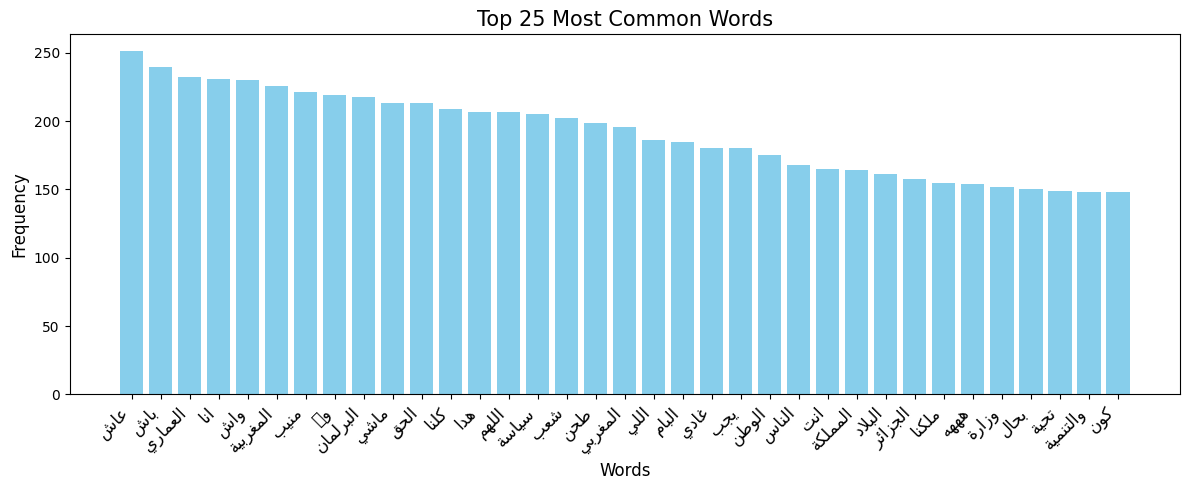

In [ ]:
# Collect all the words from all the comments
all_words = []
for t in df['cleaned_text_without_stopwords']:
    all_words.extend(t.split())

# Use Counter to count frequencies of each word
word_freq = Counter(all_words)

# Get the 25 most common words
most_common_25 = word_freq.most_common(35)

# Separate the words and their frequencies for plotting
words, freqs = zip(*most_common_25)

# Reshape and reorder Arabic text for proper display
reshaped_words = [get_display(arabic_reshaper.reshape(word)) for word in words]

# Plot the 25 most frequent words
plt.figure(figsize=(12, 5))
plt.bar(reshaped_words, freqs, color='skyblue')
plt.title('Top 25 Most Common Words', fontsize=15)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
data=df

## 4. Data Splitting:

In [ ]:
from sklearn.model_selection import train_test_split
X = data['cleaned_text_with_stopwords'].values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


## 5. Tokenization and Input Formatting

## 5.1 BERT Tokenizer

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the “attention mask”.

The encode_plus method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special [CLS] and [SEP] tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('SI2M-Lab/DarijaBERT')

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [ ]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_attention_mask=True
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Before tokenizing, we need to specify the maximum length of our sentences.



In [ ]:
# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X]

# Find the maximum length
MAX_LEN = max([len(sent) for sent in encoded_tweets])
print('Max length: ', MAX_LEN)

Max length:  88


Now let’s tokenize our data.

In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 128

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  البكاء ليس سمت الرجال البكاء سلطة الضعفاء لكسب التعاطف انا لست بنكيران وانما الرجل الصالح الذي يفعل يقول ولا يبكي الا عند النصر
Token IDs:  [2, 16480, 4825, 2347, 1010, 3703, 16480, 22951, 46624, 32392, 1025, 69942, 1996, 10999, 8259, 15725, 4484, 10766, 4661, 22972, 3304, 2084, 9483, 2234, 2026, 18510, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


### 5.2 Create PyTorch DataLoader
We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## 5. Model Training

### 5.1 Create BertClassifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.

The transformers library has the BertForSequenceClassification class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward neural network as our classifier.

In [ ]:
import torch.nn as nn

# Create the BertClassfier class
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('SI2M-Lab/DarijaBERT')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

### 5.2. Optimizer & Learning Rate Scheduler

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

Batch size: 16 or 32
Learning rate (Adam): 5e-5, 3e-5 or 2e-5
Number of epochs: 2, 3, 4

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 5.3 Training Loop

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set.

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
import numpy as np
import time
import torch
from transformers import BertModel # Import BertModel

Now, let’s start training our BertClassifier!

In [ ]:
# Function to set the random seed for reproducibility
def set_seed(seed_value=43):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

# Training function
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model."""
    # Initialize lists to store loss and accuracy for each epoch
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Acc':^9} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-" * 85)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        total_accuracy, batch_accuracy = 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1

            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out gradients
            model.zero_grad()

            # Perform forward pass and get logits
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform backward pass and update gradients
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # Compute training accuracy
            preds = torch.argmax(logits, dim=1).flatten()
            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            batch_accuracy += accuracy
            total_accuracy += accuracy

            # Print loss and accuracy every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {batch_accuracy / batch_counts:^9.2f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                batch_loss, batch_accuracy, batch_counts = 0, 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = total_accuracy / len(train_dataloader)

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        print("-" * 85)

        # =======================================
        #          Evaluation Step
        # =======================================
        if evaluation:
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {avg_train_accuracy:^9.2f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-" * 85)

        print("\n")

    print("Training complete!")

    return train_losses, train_accuracies, val_losses, val_accuracies


# Evaluation function
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set."""
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


In [ ]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train_losses, train_accuracies, val_losses, val_accuracies = train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of BertModel were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start training...

 Epoch  |  Batch  |  Train Loss  | Train Acc |  Val Loss  |  Val Acc  |  Elapsed 
-------------------------------------------------------------------------------------
   1    |   20    |   0.633904   |   64.58   |     -      |     -     |   6.89   
   1    |   40    |   0.515274   |   78.12   |     -      |     -     |   6.52   
   1    |   60    |   0.477872   |   80.94   |     -      |     -     |   6.57   
   1    |   80    |   0.468162   |   81.56   |     -      |     -     |   6.62   
   1    |   100   |   0.436554   |   82.81   |     -      |     -     |   6.64   
   1    |   120   |   0.461867   |   80.62   |     -      |     -     |   6.69   
   1    |   140   |   0.518773   |   77.50   |     -      |     -     |   6.76   
   1    |   160   |   0.550864   |   75.00   |     -      |     -     |   6.76   
   1    |   180   |   0.441508   |   81.88   |     -      |     -     |   6.78   
   1    |   200   |   0.405450   |   83.12   |     -      |     -     |   6

## 6. Predicting & Evaluating the model

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Accuracy, ROC, AUC

AUC: 0.9182
Accuracy: 85.28%


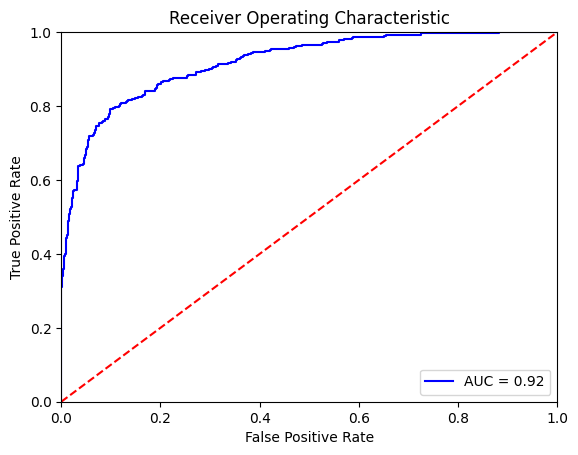

In [ ]:
import matplotlib.pyplot as plt

# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)

### Do Some Predictions

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(['يبقى غير ذي مصداقية ، ومن يغض الطرف عن الفاسدين ، متواطئ','خاصنا نديرو شي اضراب عليهم', 'تفو على حالة كي دايرا'])

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted positive: ", preds.sum())

Number of tweets predicted positive:  0


## Les défis recontrés :



**Absence de standardisation et Mélange linguistique :** Inclusion de mots étrangers (français, anglais).

**Manque de corpus :** Peu de données annotées spécifiques à la darija.

**Données bruitées :** Présence de fautes, emojis, hashtags.

**Modèles adaptés :** Ressources limitées pour la darija (ex. DarijaBERT).

**Déséquilibre des classes :** Sentiments négatifs souvent sur-représentés.

**Détection du sarcasme :** Complexité des expressions idiomatiques et sarcasmes.

**Ressources limitées :** Contraintes de calcul pour modèles complexes.
Différences régionales : Variations dialectales de la darija.
Problèmes éthiques : Confidentialité des données collectées.

## Conclusion

En conclusion, le fine-tuning de BERT a permis d'améliorer significativement l'analyse de sentiment, en capturant efficacement le contexte et les nuances linguistiques. Malgré quelques défis liés  aux données bruyantes, cette approche offre un potentiel considérable pour des analyses plus précises. Des optimisations futures peuvent encore affiner les résultats.